In [1]:
import os
import sys
from pprint import pprint
import ccxt
#import ccxt.async_support as ccxt
from pyti.exponential_moving_average import exponential_moving_average as ema
import pandas as pd
import datetime
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
from IPython.display import clear_output

# root = os.path.dirname(os.path.dirname(os.path.dirname(os.path.abspath(__file__))))
# sys.path.append(root + '/python')

# print('CCXT Version:', ccxt.__version__)

def get_last_n_kline_closes(n=50,interval='1h',symbol='BTCUSDT',exchange=None):

    if exchange is None:
        print('Exchange not initiated')
        return None
    
    # exchange = ccxt.binance({
    #     'apiKey': g_api_key,
    #     'secret': g_secret_key,
    #     'enableRateLimit': True,  
    #     'options': {
    #         'defaultType': 'future',
    #     },
    #     'hedgeMode':True
    # })
    # # symbol = 'BTC/USDT'

    # market = exchange.load_markets()
    closes = [elem[4] for elem in exchange.fapiPublic_get_klines({'symbol':symbol,'interval':interval})][-n:]
    
    return closes

def generate_signal(candles=50,interval='1h',symbol='BTCUSDT',strat='ema_cross_over_under',strat_params={'fast_ema':10,'slow_ema':40},exchange=None):

    if exchange is None:
        return 'Exchange not Initiated'

    allowed_strats = ['ema_diff_peak_trough','ema_cross_over_under','ema_oscillator_peak_trough']

    if strat not in allowed_strats:
        print('INVALID STRATEGY')
        return "NONE"

    if strat == 'ema_oscillator_peak_trough':

        '''under development'''
        return "NONE"

   
    if strat == 'ema_diff_peak_trough':
        candles = strat_params['slow_ema'] + 10

        current_input=get_last_n_kline_closes(symbol=symbol,n=candles,interval=interval,exchange=exchange)[:-1]

        min_input_length =   np.max([float(strat_params['fast_ema']),float(strat_params['slow_ema'])])

        if len(current_input)<min_input_length:
            return "INPUT HAS TOO FEW ELEMENTS"
        
        closes = pd.DataFrame(current_input,columns=['close'])
        # closes = closes[:-1]
        closes['close'] = closes['close'].astype(float)

    
        ema_diff = pd.DataFrame(ema(closes['close'].tolist(),strat_params['fast_ema']) - ema(closes['close'].tolist(),strat_params['slow_ema']),columns=['ema_diff'])
        p = strat_params['slow_ema']+1
        closes = closes[p:].reset_index(drop=True)
        ema_diff = ema_diff[p:].reset_index(drop=True)

        last = ema_diff.values[-1]
        second_last = ema_diff.values[-2]
        third_last = ema_diff.values[-3]

        # short if local peak
        if last < second_last and third_last < second_last:
            return 'SHORT'
        # long if local trough 
        if last > second_last and third_last > second_last:
            return 'LONG'
        return "NONE"
     

    if strat == 'ema_cross_over_under':
        candles = strat_params['slow_ema'] + 10

        current_input=get_last_n_kline_closes(symbol=symbol,n=candles,interval=interval,exchange=exchange)[:-1]

        min_input_length =   np.max([float(strat_params['fast_ema']),float(strat_params['slow_ema'])])

        if len(current_input)<min_input_length:
            return "INPUT HAS TOO FEW ELEMENTS"
        
        closes = pd.DataFrame(current_input,columns=['close'])
        # closes = closes[:-1]
        closes['close'] = closes['close'].astype(float)

    
        ema_diff = pd.DataFrame(ema(closes['close'].tolist(),strat_params['fast_ema']) - ema(closes['close'].tolist(),strat_params['slow_ema']),columns=['ema_diff'])
        p = strat_params['slow_ema']+1
        closes = closes[p:].reset_index(drop=True)
        ema_diff = ema_diff[p:].reset_index(drop=True)

        last = ema_diff.values[-1]
        second_last = ema_diff.values[-2]
        third_last = ema_diff.values[-3]

        # long if diff cross over 0    
        if last > 0 and second_last < 0:
            return "LONG"
        # short if diff cross under 0
        if last < 0 and second_last > 0:
            return "SHORT"
        return "NONE"


def get_open_positions(mode='live',exchange=None):

    if exchange is None:
        return 'Exchange Not Initiated'

    allowed_modes = ['live','paper']

    if mode not in allowed_modes:
        return "INVALID MODE"

    if mode == 'live':
            
        # exchange = ccxt.binance({
        #     'apiKey': g_api_key,
        #     'secret': g_secret_key,
        #     'enableRateLimit': True,
        #     'options': {
        #         'defaultType': 'future',
        #     },
        #     'hedgeMode':True
        # })

        # markets = exchange.load_markets()
        #exchange.verbose=True
        # market = exchange.market(symbol)

        positions = [elem for elem in exchange.fapiPrivate_get_positionrisk() if float(elem['positionAmt'])!=0]

        if len(positions)==0:
            return 0
        return positions

    if mode == 'paper':
        paper_trades = pd.read_csv('paper_trades.csv',index_col=0)
        if paper_trades.position_type.iloc[-1] == '-':
            return 0
        return paper_trades.iloc[-1]
        

def get_balance(mode='live',asset='USDT',exchange=None):

    if exchange is None:
        return 'Exchange not initiated'

    allowed_modes = ['paper','live']

    if mode not in allowed_modes:
        print("INVALID MODE")
        return None
            
    # exchange = ccxt.binance({
    #         'apiKey': g_api_key,
    #         'secret': g_secret_key,
    #         'enableRateLimit': True, 
    #         'options': {
    #             'defaultType': 'future',
    #         },
    #         'hedgeMode':True
    #     })
    # markets = exchange.load_markets()


    if mode == 'live':
        live_balance = str(float([float(elem['balance']) for elem in exchange.fapiPrivate_get_balance() if elem['asset']==asset][0]))
        unrealized_pnl = str(sum([float(elem['unRealizedProfit']) for elem in exchange.fapiPrivateV2_get_positionrisk() if float(elem['positionAmt']) >0]))
        unrealized_pnl_percent = str(float(unrealized_pnl)/float(live_balance))

        balance = {'wallet_balance': live_balance,
                    'unrealized_pnl_percent': unrealized_pnl_percent}
                    
        return balance

    if mode == 'paper':
        
        paper_trades = pd.read_csv('paper_trades.csv',index_col=0)

        if paper_trades.paper_equity.iloc[-1] == '-':
            paper_balance = paper_trades.paper_equity.iloc[-2]
        else:
            paper_balance = paper_trades.paper_equity.iloc[-1]

        if paper_trades.entry_price.iloc[-1] == '-':
            entry = None
        else:
            entry = paper_trades.entry_price.iloc[-1]

        if paper_trades.position_type.iloc[-1] == 'LONG':
            position = 1
        if paper_trades.position_type.iloc[-1] == 'SHORT':
            position = -1
        else:
            position = 0

        if entry is not None and position != 0:

            if paper_trades.exit_price.iloc[-1] == '-':
                
                symbol = paper_trades.market_name.iloc[-1]
                
                last_price = float(exchange.fapiPublic_get_ticker_price({'symbol':symbol})['price'])

                pnl = (last_price-float(entry))/float(entry)*100*float(position)

            else:
                pnl = 0

        else:
            pnl = 0

        balance = {'wallet_balance':paper_balance,'unrealized_pnl_percent':pnl}

        return balance    
        

def close_all_open_positions(mode='live',exchange=None):

    if exchange is None:
        return 'Exchange not Initiated'

    allowed_modes = ['paper','live']
    if mode not in allowed_modes:
        return "INVALID MODE"

    if mode == 'live':
            
        # exchange = ccxt.binance({
        #         'apiKey': g_api_key,
        #         'secret': g_secret_key,
        #         'enableRateLimit': True,
        #         'options': {
        #             'defaultType': 'future',
        #         },
        #         'hedgeMode':True
        #     })

        # markets = exchange.load_markets()
        #exchange.verbose=True
        # market = exchange.market(symbol)

        open_positions = get_open_positions(mode=mode,exchange=exchange)
        if open_positions == 0:
            return None
        
        if np.sign(float(open_positions[0]['positionAmt'])) == -1.0:
            opp_side = "BUY"
        if np.sign(float(open_positions[0]['positionAmt'])) == 1.0:
            opp_side = "SELL" 
        baseqty= abs(float(open_positions[0]['positionAmt']))
        symbol = open_positions[0]['symbol']
        positionSide = open_positions[0]['positionSide']
        order = exchange.fapiPrivatePostOrder({'symbol':symbol, 'type':"MARKET", 'side':opp_side,'positionSide':positionSide ,'quantity':baseqty})

        return order

    if mode == 'paper':
        paper_trades = pd.read_csv('paper_trades.csv',index_col=0)
        if paper_trades.position_type.iloc[-1] == '-':
            return None
    
        if paper_trades.exit_price.iloc[-1] != '-':
            return None
        # exchange = ccxt.binance({
        #     'apiKey': g_api_key,
        #     'secret': g_secret_key,
        #     'enableRateLimit': True, 
        #     'options': {
        #         'defaultType': 'future',
        #     },
        #     'hedgeMode':True
        # })
        # markets = exchange.load_markets()
        
        symbol = paper_trades.market_name.iloc[-1]
        entry_price = paper_trades.entry_price.iloc[-1]
        leverage= paper_trades.leverage.iloc[-1]
        leverage = int(leverage)

        if paper_trades.position_type.iloc[-1] == 'LONG':
            position = 1
            exit_price = 0.999*float(exchange.fapiPublic_get_ticker_price({'symbol':symbol})['price'])
            exit_time = datetime.datetime.utcnow()
    

        if paper_trades.position_type.iloc[-1] == 'SHORT':
            position = -1
            exit_price = 1.001*float(exchange.fapiPublic_get_ticker_price({'symbol':symbol})['price'])
            exit_time = datetime.datetime.utcnow()

        
        trade_pnl_pct = float(position)*float(leverage)*(float(exit_price)-float(entry_price))/float(entry_price)*100
        balance = float(paper_trades.paper_equity.iloc[-2])*(1+trade_pnl_pct/100)

        paper_trades.exit_time.iloc[-1] = exit_time
        paper_trades.exit_price.iloc[-1] = exit_price
        paper_trades.trade_pnl_pct.iloc[-1] = trade_pnl_pct
        paper_trades.paper_equity.iloc[-1] = balance

        paper_trades.to_csv('paper_trades.csv')

        trade = paper_trades.iloc[-1]

        return trade
        
def open_market_order(mode='live',balance=1,symbol='BTCUSDT',leverage="5",side="BUY",hedge_mode="BOTH",exchange=None):

    if exchange is None:
        return 'Exchange not initiated'

    allowed_modes = ['paper','live']

    if mode not in allowed_modes:
        return "INVALID MODE"

    if mode == 'live':

        closed_position =  close_all_open_positions(mode=mode,exchange=exchange)

        quoteqty = float([elem for elem in exchange.fapiPrivate_get_balance({'asset':"USDT"}) if elem['asset']=='USDT'][0]['balance']) * balance
        price = float(exchange.fapiPublic_get_ticker_price({'symbol':symbol})['price'])
        baseqty = "{:.3f}".format(quoteqty*float(leverage)/price)
        baseqty = float(baseqty)-float([elem for elem in exchange.fapiPublic_get_exchangeinfo()['symbols'] if elem['symbol']==symbol][0]['filters'][2]['minQty'])
        baseqty = "{:.3f}".format(baseqty)
        baseqty = str(baseqty)
        lev_req = exchange.fapiPrivate_post_leverage({'symbol':symbol,'leverage':leverage})
        order = exchange.fapiPrivatePostOrder({'symbol':symbol, 'type':"MARKET", 'side':side,'positionSide':hedge_mode ,'quantity':baseqty})

        return order,closed_position
    
    if mode == 'paper':
        closed_position = close_all_open_positions(mode=mode,exchange=exchange)

        
        paper_trades = pd.read_csv('paper_trades.csv',index_col=0)

        
        if side == 'BUY':
            position_type = 'LONG'
            entry_price = 1.001*float(exchange.fapiPublic_get_ticker_price({'symbol':symbol})['price'])
            entry_time = datetime.datetime.utcnow()
        if side == 'SELL':
            position_type = 'SHORT'
            entry_price = 0.999*float(exchange.fapiPublic_get_ticker_price({'symbol':symbol})['price'])
            entry_time = datetime.datetime.utcnow()

        trade = pd.DataFrame([[symbol,position_type,entry_time,'-', entry_price,'-',leverage,'-','-']],columns=['market_name','position_type','entry_time','exit_time','entry_price','exit_price','leverage','trade_pnl_pct','paper_equity'])
        paper_trades = paper_trades.append(trade,ignore_index=True)

        paper_trades.to_csv('paper_trades.csv')

        return paper_trades.iloc[-1],closed_position


def get_strat_performance(strat='ema_cross_over_under',leverage=1,strat_params={'fast_ema':4,'slow_ema':20},interval='4h',symbol='BTCUSDT',candles=50,input=None,exchange=None):

    if exchange is None:
        return 'Exchange not initiated'
    
    allowed_strats = ['ema_cross_over_under','ema_diff_peak_trough']
    if strat not in allowed_strats:
        print("INVALID STRATEGY")
        return None

    if input == None:
        current_input=get_last_n_kline_closes(symbol=symbol,n=candles,interval=interval,exchange=exchange)

    else:
        current_input = input
    
    closes = pd.DataFrame(current_input,columns=['close'])
    closes = closes[:-1]
    closes['close'] = closes['close'].astype(float)

    ema_diff = pd.DataFrame(ema(closes['close'].tolist(),strat_params['fast_ema']) - ema(closes['close'].tolist(),strat_params['slow_ema']),columns=['ema_diff'])
    p = strat_params['slow_ema']+1
    closes = closes[p:].reset_index(drop=True)
    ema_diff = ema_diff[p:].reset_index(drop=True)

    if strat == 'ema_cross_over_under':
        signal = [0]+[1 if float(ema_diff.loc[index]) > 0 and float(ema_diff.loc[index-1]) < 0 else -1 if float(ema_diff.loc[index]) < 0 and float(ema_diff.loc[index-1]) > 0  else 0 for index in ema_diff.index[1:]]

    if strat == 'ema_diff_peak_trough':
        signal = [0,0]+ [-1 if float(ema_diff.loc[index]) < float(ema_diff.loc[index-1]) and float(ema_diff.loc[index-1]) > float(ema_diff.loc[index-2]) else 1 if float(ema_diff.loc[index]) > float(ema_diff.loc[index-1]) and float(ema_diff.loc[index-1]) < float(ema_diff.loc[index-2]) else 0 for index in ema_diff.index[2:]]

    trades = list()
    for idx in range(len(signal)):
        if signal[idx] != 0:
            trades.append([closes.loc[idx],signal[idx]])
    result = list()
    for idx in range(len(trades)):
        if idx > 0:
            position = trades[idx-1][1] * leverage
            performance = position * ((trades[idx][0]['close'] - trades[idx-1][0]['close']) / trades[idx-1][0]['close'])*100 
            trade = [position,performance]
            result.append(trade)

    equity_curve = list()
    principal = 1
    for elem in result:
        principal = principal * (1 + elem[1]/100)
        # print(principal)
        equity_curve.append(principal)
    pd.DataFrame(equity_curve).plot()
    

    trade_pnl = list()
    principal = 1
    for elem in result:
        pnl=elem[1]
        # print(principal)
        trade_pnl.append(pnl)
    pd.DataFrame(trade_pnl).plot(kind='bar')


def get_strat_price_ti_plot(strat='ema_cross_over_under',strat_params={'fast_ema':4,'slow_ema':20},symbol='DEFIUSDT',interval='4h',candles=50,exchange=None):

    if exchange is None:
        return 'Exchange not initiated'

    allowed_strats = ['ema_cross_over_under','ema_diff_peak_trough','ema_oscillator_peak_trough']

    if strat not in allowed_strats:
        print("INVALID STRATEGY")
        return None

    if strat == 'ema_oscillator_peak_trough':

        '''in devlopment'''
        # current_input=get_last_n_kline_closes(symbol=symbol,n=candles,interval=interval)[:-1]

        # closes = pd.DataFrame(current_input,columns=['close'])
        # # closes = closes[:-1]
        # closes['close'] = closes['close'].astype(float)

        # ema_oscillator = list()

        return None


    if strat == 'ema_cross_over_under':
        
        current_input=get_last_n_kline_closes(symbol=symbol,n=candles,interval=interval,exchange=exchange)[:-1]

        closes = pd.DataFrame(current_input,columns=['close'])
        # closes = closes[:-1]
        closes['close'] = closes['close'].astype(float)

        indicator = pd.DataFrame(ema(closes['close'].tolist(),strat_params['fast_ema']) - ema(closes['close'].tolist(),strat_params['slow_ema']),columns=['ema_diff'])
        p = strat_params['slow_ema']+1
        closes = closes[p:].reset_index(drop=True)
        indicator = indicator[p:].reset_index(drop=True)

        signal = [0]+[1 if float(indicator.loc[index]) > 0 and float(indicator.loc[index-1]) < 0 else -1 if float(indicator.loc[index]) < 0 and float(indicator.loc[index-1]) > 0  else 0 for index in indicator.index[1:]]

    if strat == 'ema_diff_peak_trough':
        current_input=get_last_n_kline_closes(symbol=symbol,n=candles,interval=interval,exchange=exchange)[:-1]

        closes = pd.DataFrame(current_input,columns=['close'])
        # closes = closes[:-1]
        closes['close'] = closes['close'].astype(float)

        indicator = pd.DataFrame(ema(closes['close'].tolist(),strat_params['fast_ema']) - ema(closes['close'].tolist(),strat_params['slow_ema']),columns=['ema_diff'])
        p = strat_params['slow_ema']+1
        closes = closes[p:].reset_index(drop=True)
        indicator = indicator[p:].reset_index(drop=True)

        signal = [0,0]+ [-1 if float(indicator.loc[index]) < float(indicator.loc[index-1]) and float(indicator.loc[index-1]) > float(indicator.loc[index-2]) else 1 if float(indicator.loc[index]) > float(indicator.loc[index-1]) and float(indicator.loc[index-1]) < float(indicator.loc[index-2]) else 0 for index in indicator.index[2:]]


    fig, (ax1,ax2) = plt.subplots(nrows=2, sharex=True, subplot_kw=dict(frameon=True)) # frameon=False removes frames

    x = range(len(signal))
    # plt.subplots_adjust(hspace=.0)
    ax1.grid()
    ax1.plot(x, closes.values, color='b')
    for i in range(len(signal)):
        if signal[i] == 1:
            ax1.axvline(i,color='g')
        if signal[i] == -1:
            ax1.axvline(i,color='r')
    # closes.plot()
    ax1.axhline(closes.values[-1],color='k')
    ax1.legend([str(symbol)+': '+  str(closes.values[-1]) + ' @ '+ str(datetime.datetime.utcnow())+' UTC'])

    ax2.grid()
    ax2.plot(x, indicator.values, color='b', linestyle='--')
    # indicator.plot()
    for i in range(len(signal)):
        if signal[i] == 1:
            ax2.axvline(i,color='g')
        if signal[i] == -1:
            ax2.axvline(i,color='r')
    ax2.axhline(0,color='k')
    ax2.legend([str(strat) + ': '+ str(indicator.values[-1]) ])

    plt.show()



def runner(mode='live',symbol='BTCUSDT',candles=50,interval='1h',asset='USDT',strat='ema_cross_over_under',strat_params = {'fast_ema':10,'slow_ema':40},short_leverage="2",long_leverage="4",user_api_key=None,user_secret_key=None):

    if user_secret_key is None or user_api_key is None:
        return 'API keys missing'

    allowed_intervals = ['1d','6h','4h','1h','15m','5m']    
    
    if interval not in allowed_intervals:
        print("Invalid Interval")
        return None
    
    check_hours_1d = [0]
    check_hours_6h = [0,6,12,18]
    check_hours_4h = [0,4,8,12,16,20]
    check_hours_1h = [i for i in range(24)]
    check_minutes_h = [0]
    check_minutes_15m = [0,15,30,45]
    check_minutes_5m = [0,5,10,15,20,25,30,35,40,45,50,55]

    if interval == '1h':
        check_hours = check_hours_1h
        check_minutes = check_minutes_h

    if interval == '4h':
        check_hours = check_hours_4h
        check_minutes = check_minutes_h

    if interval == '6h':
        check_hours = check_hours_6h
        check_minutes = check_minutes_h

    if interval == '1d':
        check_hours = check_hours_1d
        check_minutes = check_minutes_h
    
    if interval == '15m':
        check_hours = check_hours_1h
        check_minutes = check_minutes_15m
        
    if interval == '5m':
        check_hours = check_hours_1h
        check_minutes = check_minutes_5m

    allowed_modes = ['paper','live']
    if mode not in allowed_modes:
        print("INVALID MODE")
        return None

    if mode == 'live':

        print("Starting in Live Mode")
        print("Time Started:")
        print(datetime.datetime.utcnow())  

        ### Run while true loop in perpetuity unless explicitly terminated by a KeyboardInterrupt ###
        while True:

            try:
                if datetime.datetime.utcnow().minute in check_minutes and  datetime.datetime.utcnow().hour in check_hours:
                    time.sleep(3)

                    exchange = ccxt.binance({
            'apiKey': user_api_key,
            'secret': user_secret_key,
            'enableRateLimit': True, 
            'options': {
                'defaultType': 'future',
            },
            'hedgeMode':True
        })
                    markets = exchange.load_markets()    

                    clear_output(wait=True)
                    get_strat_price_ti_plot(strat=strat,strat_params=strat_params,symbol=symbol,interval=interval,candles=candles,exchange=exchange)

                    try:
                        balance = get_balance(mode=mode,asset=asset)
                    except Exception as e:
                        print("Failed to get account balance,Retrying...")
                        time.sleep(10)
                        print(e)
                        continue
                    # print("Margin Balance @ ",end="",flush=True)
                    # print(datetime.datetime.utcnow())
                    # print("Wallet Balance = "+balance['wallet_balance'])
                    # print("Unrealized PnL = "+balance['unrealized_pnl_percent'])

                    try:
                        current_signal = generate_signal(candles=strat_params['slow_ema']+10,interval=interval,symbol=symbol,strat=strat,strat_params = strat_params,exchange=exchange)
                    except Exception as e:
                        print("Failed to generate signal,Retrying...")
                        time.sleep(10)
                        print(e)
                        continue
                    # print("Current Signal:")
                    # print(current_signal)

                    try:
                        order = get_open_positions(mode=mode,exchange=exchange)
                        if order == 0:
                            current_exposure = "NONE"
                        else:
                            current_exposure = np.sign(float(order[0]['positionAmt']))
                        
                        if current_exposure == 1.0:
                            current_exposure = "LONG"

                        if current_exposure == -1.0:
                            current_exposure = "SHORT"

                    except Exception as e:
                        print("Failed to get current exposure,Retrying...")
                        time.sleep(10)
                        print(e)
                        continue
                    # print("Current Exposure:")
                    # print(current_exposure)

                    try:
                        closes = get_last_n_kline_closes(n=candles,interval=interval,symbol='BTCUSDT',exchange=exchange)
                        last = closes[-2]
                        second_last = closes[-3]
                    except Exception as e:
                        print('Failed to get last n klines')
                        time.sleep(10)
                        print(e)
                        continue

                    if current_exposure == 'LONG':
                        if last < second_last:
                            closed_order = close_all_open_positions(mode='paper')
                    if current_exposure == 'SHORT':
                        if last > second_last:
                            closed_order = close_all_open_positions(mode='paper')


                    if current_signal == "NONE":
                        time.sleep(60)
                        continue
                    
                    if current_signal == 'LONG':         
                        # print("Opening Long Position")
                        while True:
                            try:
                                order,closed_position = open_market_order(mode=mode,balance=1,symbol=symbol,leverage=long_leverage,side="BUY",exchange=exchange)
                                # print("Details of Opened Long Position:")
                                # print(order)
                                time.sleep(60)
                                break
                            except Exception as e:
                                print("Failed to Open Long Position,Retrying...")
                                print(e)
                                time.sleep(10)
                                continue


                    if current_signal == 'SHORT':        
                        # print("Opening Short")
                        while True:
                            try:
                                order,closed_position = open_market_order(mode=mode,balance=1,symbol=symbol,leverage=short_leverage,side="SELL")
                                # print("Details of Opened Short Position:")
                                # print(order)
                                time.sleep(60)
                                break
                            except Exception as e:
                                print("Failed to Open Short Position,Retrying...")
                                print(e)
                                time.sleep(10)
                                continue

            except Exception as e:
                print("Iteration Failed,Retrying...")
                print(e)
        

    if mode == 'paper':

        print("Starting in Paper Mode")
        print("Time Started:")
        print(datetime.datetime.utcnow())

      
        ### Run while loop in perpetuity unless explicitly terminated by a KeyboardInterrupt ###
        while True:

            try:

                if datetime.datetime.utcnow().minute in check_minutes and  datetime.datetime.utcnow().hour in check_hours:

                    time.sleep(3)

                    exchange = ccxt.binance({
            'apiKey': user_api_key,
            'secret': user_secret_key,
            'enableRateLimit': True, 
            'options': {
                'defaultType': 'future',
            },
            'hedgeMode':True
        })
                    markets = exchange.load_markets()    

                    clear_output(wait=True)
                    get_strat_price_ti_plot(strat=strat,strat_params=strat_params,symbol=symbol,interval=interval,candles=candles,exchange=exchange)



                    # print("New Candle Detected")
                    
                    try:
                        balance = get_balance(mode=mode,asset=asset)
                    except Exception as e:
                        print("Failed to get account balance,Retrying...")
                        time.sleep(10)
                        print(e)
                        continue
                    # print("Margin Balance @ ",end="",flush=True)
                    # print(datetime.datetime.utcnow())
                    # print("Wallet Balance = "+str(balance['wallet_balance']))
                    # print("Unrealized PnL = "+str(balance['unrealized_pnl_percent']))

                    try:
                        current_signal = generate_signal(candles=strat_params['slow_ema']+10,interval=interval,symbol=symbol,strat=strat,strat_params= strat_params,exchange=exchange)
                    except Exception as e:
                        print("Failed to generate signal,Retrying...")
                        time.sleep(10)
                        print(e)
                        continue
                    # print("Current Signal:")
                    # print(current_signal)

                    try:
                        order = get_open_positions(mode=mode,exchange=exchange)
                        if type(order) == int:
                            current_exposure = "NONE"
                        else:
                            current_exposure = order['position_type']
                        
                    except Exception as e:
                        print("Failed to get current exposure,Retrying...")
                        time.sleep(10)
                        print(e)
                        continue
                    # print("Current Exposure:")
                    # print(current_exposure)

                    try:
                        closes = get_last_n_kline_closes(n=candles,interval=interval,symbol='BTCUSDT',exchange=exchange)
                        last = closes[-2]
                        second_last = closes[-3]
                    except Exception as e:
                        print('Failed to get last n klines')
                        time.sleep(10)
                        print(e)
                        continue

                    if current_exposure == 'LONG':
                        if last < second_last:
                            closed_order = close_all_open_positions(mode='paper')
                    if current_exposure == 'SHORT':
                        if last > second_last:
                            closed_order = close_all_open_positions(mode='paper')

                    if current_signal == "NONE":
                        time.sleep(60)
                        continue
                    
                    if current_signal == 'LONG':
                            
                        print("Opening Long")
                        while True:
                            try:
                                order,closed_position = open_market_order(mode=mode,balance=1,symbol=symbol,leverage=long_leverage,side="BUY",exchange=exchange)
                                # print("Details of Opened Long Position:")
                                # print(order)
                                time.sleep(60)
                                break
                            except Exception as e:
                                print("Failed to Open Long Position,Retrying...")
                                print(e)
                                time.sleep(10)
                                continue


                    if current_signal == 'SHORT':
                            
                        print("Opening Short")
                        while True:
                            try:
                                order,closed_position = open_market_order(mode=mode,balance=1,symbol=symbol,leverage=short_leverage,side="SELL",exchange=exchange)
                                # print("Details of Opened Short Position:")
                                # print(order)
                                time.sleep(60)
                                break
                            except Exception as e:
                                print("Failed to Open Short Position,Retrying...")
                                print(e)
                                time.sleep(10)
                                continue
                    
            except Exception as e:
                print("Iteration Failed,Retrying...")
                print(e)
               
# runner(mode='paper',symbol='DEFIUSDT',candles=30,interval='5m',asset='USDT',strat='ema_cross_over_under',strat_params={'fast_ema':4,'slow_ema':20},short_leverage="1",long_leverage="1")

# def risk_manager(mode='live',symbol='BTCUSDT',interval='4h',)


In [9]:
'''intialize and save paper trades dataframe'''
starting_paper_balance = 10000

paper_trades = pd.DataFrame([],columns=['market_name','position_type','entry_time','exit_time','entry_price','exit_price','leverage','trade_pnl_pct','paper_equity'])

trade = pd.DataFrame([['-','-','-','-','-','-','-','-',starting_paper_balance]],columns=['market_name','position_type','entry_time','exit_time','entry_price','exit_price','leverage','trade_pnl_pct','paper_equity'])
paper_trades = paper_trades.append(trade,ignore_index=True)

paper_trades.to_csv('paper_trades.csv')

In [2]:
g_api_key =    "yvZrfjvPSaICC0XyQjE2wSJxFwwnQuuay6IT4yEXhvrKOl0lINutgLVaMLujWWxe"
g_secret_key = "TAWFZOhfEkCVAP52XlZAGTXHeKRbWlvX0zBvEoippbhumPvIQnZZGYEo4gr4Xko9"

# runner(mode='paper',symbol='BTCUSDT',candles=100,interval='4h',asset='USDT',strat='ema_cross_over_under',strat_params={'fast_ema':4,'slow_ema':20},short_leverage='10',long_leverage ='10',user_api_key=g_api_key,user_secret_key=g_secret_key)

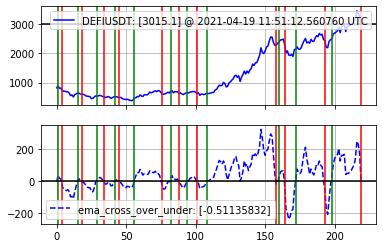

In [9]:
exchange = ccxt.binance({
'apiKey': g_api_key,
'secret': g_secret_key,
'enableRateLimit': True, 
'options': {
'defaultType': 'future',
},
'hedgeMode':True
})

markets = exchange.load_markets()

get_strat_price_ti_plot(strat='ema_cross_over_under',strat_params={'fast_ema':3,'slow_ema':13},symbol='DEFIUSDT',interval='1d',candles=250,exchange=exchange)

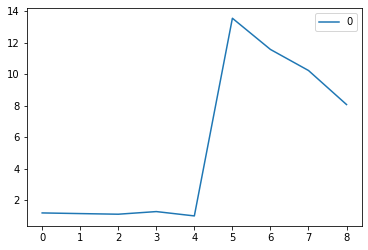

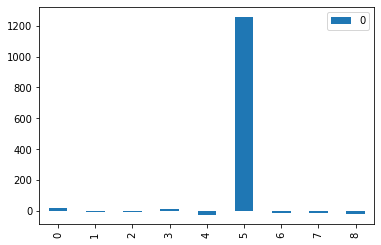

In [15]:
get_strat_performance(strat='ema_cross_over_under',leverage=1,strat_params={'fast_ema':10,'slow_ema':40},interval='1d',symbol='DOGEUSDT',candles=500,exchange=exchange)

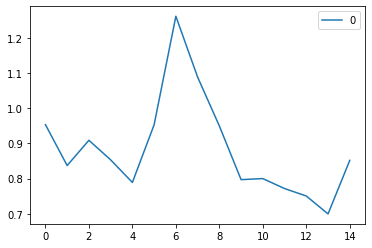

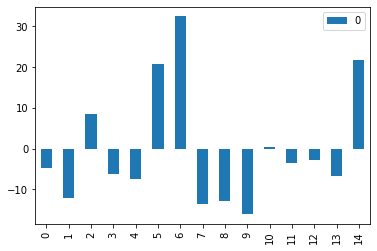

In [17]:
get_strat_performance(strat='ema_cross_over_under',leverage=2,strat_params={'fast_ema':4,'slow_ema':20},interval='4h',symbol='DEFIUSDT',candles=250,exchange=exchange)

In [ ]:
get_balance(mode='live',asset='USDT')

close_all_open_positions(mode='live')

open_market_order(mode='live',balance=1,symbol='BTCUSDT',leverage="5",side="BUY",hedge_mode="BOTH")

get_strat_performance(strat='ema_cross_over_under',leverage=1,fast_ema=4,slow_ema=20,interval='4h',symbol='BTCUSDT',candles=50)




In [12]:
get_strat_performance(strat='ema_cross_over_under',leverage=1,strat_params = {'fast_ema':4,'slow_ema':20},interval='4h',symbol='BTCUSDT',candles=200)

'Exchange not initiated'